   ### **Actividad 03 Reglas de Asociación  (Algoritmo Apriori)**

Universidad Nacional de San Antonio Abad del Cusco

Asignatura: Mineria de Datos

Docente   : Carlos Fernando Montoya Cubas

Autor     : Vladir Dante Casilla Percca

Fecha     : 25/11/2021

Lugar     : Cusco, Perú

Proposito : Implementar el algoritmo apriori(reglas de asociacion)

### 1.-Instalar bibliotecas

In [1]:
import numpy as np
import itertools 

**Para generar combinarion de elementos de una lista, ademàs esto nos servirá para: El módulo estandariza un conjunto básico de herramientas rápidas y eficientes en memoria que son útiles por sí mismas o en combinación. Juntos, forman un “álgebra de iteradores” que hace posible construir herramientas especializadas de manera sucinta y eficiente en Python puro**

In [27]:
import pandas as pd
import numpy as np
import collections
from collections import defaultdict

### 2.-Importacion de la Base de Datos (spotify.npy) 🟠

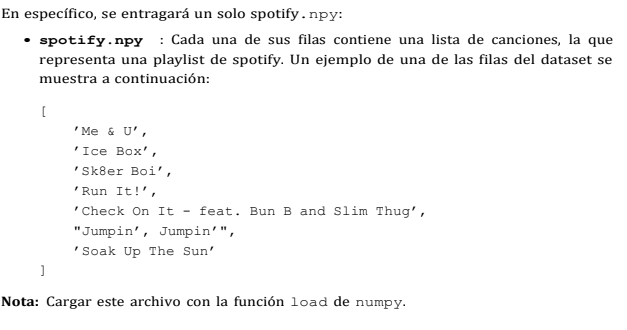

In [28]:
from IPython.display import Image
Image(filename='Captura6.png')

**Importar la DATASET**

In [29]:
db = np.load("spotify.npy", allow_pickle = True)

### 3. Implementar el algoritmo Apriori

**-Para estructurar mejor el código, se implementó  las siguientes funciones:**

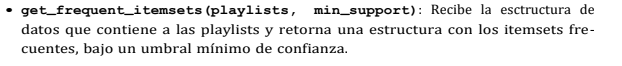

In [30]:
Image(filename='Captura2.png')

In [31]:
def get_frequent_itemsets(playlists, min_support):
  #Se convierte los datos en listas de conjuntos, tambien se genera la frecuencia de cada cancion
  playlists = list(playlists.item().values())
  playlists = [set(playlist) for playlist in playlists]
  canciones = [item for sublist in playlists for item in sublist]
  contador_canciones = pd.Series(data=canciones).value_counts().to_dict()
  #Se genera un diccionario de canciones y los indices de las playlists en las que tambien estan incluidas
  canciones_playlists = collections.defaultdict(set)
  for index, playlist in enumerate(playlists):
      for cancion in playlist:
          canciones_playlists[cancion].add(index)
  canciones_playlists = canciones_playlists
  #Se obtienen los itemsets de las canciones que aparecen un porcentaje de veces mayor al umbral minimo de soporte
  _contador = {cancion: veces for cancion, veces in contador_canciones.items() if veces / len(playlists) >= min_support}
  _itemset = [{cancion} for cancion in _contador.keys()]
  #Se obtienen los itemsets mas frecuentes
  _itemsets_frecuentes = {}
  _itemsets_frecuentes[1] = sorted(_contador.items(), key=lambda x: x[1], reverse=True)
  _itemsets_frecuentes_size = []
  k = 2
  actual = _itemset   #current :actual
  while len(actual) != 0:
    #Generar itemsets candidatos
    combinaciones = set() 
    m = k - 2
    for candidato in actual: 
      candidato = list(candidato)
      for aux_candidato in actual:
        aux_candidato = list(aux_candidato)
        union = True
        for i in range(k - 2):
          if candidato[i] != aux_candidato[i]:
              union = False
              break
        if not union:
          continue
        if candidato[k - 2] < aux_candidato[k - 2]:
          c = candidato + [aux_candidato[k - 2]]
          c = frozenset(sorted(c))
          combinaciones.add(c)
    #Generar el itemset que cumplan con la condicion del umbral minimo de soporte
    contador_combinaciones = {}   
    playlist_tamanio = len(playlists)   
    for candidato in combinaciones:
        playlists_inter = []
        for song in candidato:
          playlists_inter.append(canciones_playlists[song])
        contador_combinaciones[candidato] = len(set.intersection(*playlists_inter))
    contador_l = {subset: veces for subset, veces in contador_combinaciones.items() if veces / playlist_tamanio >= min_support} 
    diccionario_l = contador_l.keys() 
    _itemsets_frecuentes_size.extend(diccionario_l)
    _itemsets_frecuentes[k] = sorted(contador_l.items(), key=lambda x: x[1], reverse=True)
    k += 1
    actual = diccionario_l
  #Generar los itemsets en un dataframe
  _itemsets_df = pd.DataFrame([item for sublist in _itemsets_frecuentes.values() for item in sublist]).round(3)
  _itemsets_df.columns = ["itemset", "contador_support"]
  _itemsets_df["support"] = _itemsets_df["contador_support"] / len(playlists)
  #La funcion retornara un vector con 4 datos
  extra_data = []
  #En la primera posicion estaran los itemsets mas frecuentes.
  extra_data.append(_itemsets_df)
  #En la segunda posicion estaran los datos de la playlist para un posterior uso.
  extra_data.append(playlists)
  #En la tercera posicion estara el registro de las canciones que estan en las playlists.
  extra_data.append(canciones_playlists)
  #En la cuarta posicion estaran el registro de los itemsets largos para un posterior uso.
  extra_data.append(_itemsets_frecuentes_size)
  return extra_data

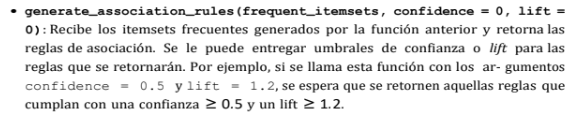

In [32]:
Image(filename='Captura3.png')

In [33]:
#Funcion para generar las reglas de asociacion
def generate_association_rules(frequent_itemsets, confidence, lift):
  reglas = []
  for itemset in frequent_itemsets[3]:
    #Se forman todas las combinaciones posibles de X -> Y, donde X ⊂ I y Y = I - X
    itemset_contador = calcular_inter(itemset,frequent_itemsets[2])
    itemset_support = itemset_contador / len(frequent_itemsets[0])
    for i in range(1, len(itemset) + 1):
        for x_set in combinations(itemset, i):
            x_set = set(x_set)
            y_set = set(itemset) - x_set
            x_support = calcular_inter(x_set,frequent_itemsets[2]) / len(frequent_itemsets[0])
            x_y_support = calcular_inter(x_set.union(y_set),frequent_itemsets[2]) / len(frequent_itemsets[0])
            rule_confidence = x_y_support / x_support
            if len(x_set) > 0 and len(y_set) > 0:
                y_support = calcular_inter(y_set,frequent_itemsets[2]) / len(frequent_itemsets[0])
                rule_lift = x_y_support / (x_support * y_support)
                reglas.append((x_set, y_set, rule_confidence, x_y_support, rule_lift))
  #Generar dataframe de las reglas de asociacion
  reglas_df = pd.DataFrame(data=reglas, columns=["X", "Y", "confidence", "support", "lift"]).round(3)
  reglas_df["X"] = list(map(tuple, reglas_df["X"]))
  reglas_df["Y"] = list(map(tuple, reglas_df["Y"]))

  #Hallar las reglas de asociacion de 10 elementos para la confianza
  order_by="confidence"
  n=10
  confidence_df = reglas_df.sort_values(order_by, ascending=False).head(n)

  #Hallar las reglas de asociacion de 10 elementos para lift
  order_by="lift"
  n=10
  lift_df2 = reglas_df.sort_values(order_by, ascending=False).head(n)

  #Hallar las reglas de asociacion que cumplan con la condicion de confianza y lift
  reglas_df["len_itemset"] = reglas_df.apply(lambda x: len(set(x["X"]).union(set(x["Y"]))), axis=1)
  reglas_df=reglas_df.sort_values(by="len_itemset", ascending=False)
  both_rules = reglas_df[(reglas_df["confidence"] >= confidence) & (reglas_df["lift"] >= lift)]

  return confidence_df,lift_df2,both_rules

### 4. Secundarios:

**Modulo para crear interseccion de los itemset**

In [34]:

def calcular_inter(subset,canciones_playlist):
    playlists_inter = []
    for song in subset:
        playlists_inter.append(canciones_playlist[song])
    return len(set.intersection(*playlists_inter))

**Modulo para generar combinaciones en los itemsets**  

In [35]:
def combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(pool[i] for i in indices)

**Generamos las reglas de asociacion, estableciendo una confianza de 0.5 y  de lift reglas que se retornarán con un valor de 1.2**

In [49]:
reglas_confidence,reglas_lift,reglas_ambos = generate_association_rules(itemsets,0.5,1.2)

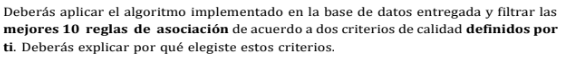

In [55]:
Image(filename='Captura7.png')

**Ahora imprimiremos una lista de 10 reglas que cumplen el mayor limite con
respecto a la CONFIDENCE y  LIFT**

In [52]:
reglas_ambos.head(10)

,X,Y,confidence,support,lift,len_itemset
447,"(HUMBLE., XO TOUR Llif3)","(Mask Off,)",0.642,0.128,2.081,3
362,"(Mask Off, goosebumps)","(HUMBLE.,)",0.743,0.107,1.637,3
367,"(Mask Off, XO TOUR Llif3)","(Congratulations,)",0.656,0.104,1.668,3
368,"(Mask Off, Congratulations)","(XO TOUR Llif3,)",0.660,0.104,2.094,3
369,"(XO TOUR Llif3, Congratulations)","(Mask Off,)",0.598,0.104,1.937,3
373,"(HUMBLE., Bad and Boujee (feat. Lil Uzi Vert))","(Congratulations,)",0.605,0.099,1.537,3
375,"(Bad and Boujee (feat. Lil Uzi Vert), Congratu...","(HUMBLE.,)",0.678,0.099,1.493,3
379,"(Mask Off, goosebumps)","(XO TOUR Llif3,)",0.682,0.099,2.164,3
380,"(Mask Off, XO TOUR Llif3)","(goosebumps,)",0.620,0.099,2.060,3
381,"(goosebumps, XO TOUR Llif3)","(Mask Off,)",0.664,0.099,2.153,3


### Obtencion de las reglas de asoacion 

In [59]:
seleccion4reglas=reglas_lift.head(4)
seleccion4reglas

,X,Y,confidence,support,lift
329,"(No Heart,)","(X (feat. Future),)",0.696,0.101,3.493
328,"(X (feat. Future),)","(No Heart,)",0.505,0.101,3.493
314,"(Knee Deep (feat. Jimmy Buffett),)","(Chicken Fried,)",0.682,0.104,3.261
315,"(Chicken Fried,)","(Knee Deep (feat. Jimmy Buffett),)",0.500,0.104,3.261


### Explicar reglas obtenidas


Primera regla

          (No Heart,) ---> (X (feat. Future),)
          
Se toma en cuenta que ambas canciones son de genero rap y su relacion puede estar ligada al gusto musical de este genero. Y se cumple con la regla de confidence ≥ 0.5 

Segunda regla

         (X (feat. Future),) ---> (No Heart,)
         
Se repiten las mismas canciones de la anterior regla, de la misma manera en la que se analizo la anterior cancion, la confianza en esta regla supera el umbral predefinido ≥ 0.5 y cumple con el criterio.

Tercera regla

         (Knee Deep (feat. Jimmy Buffett),) ---> (Chicken Fried,)
         
Estas canciones son de genero country - folk, su relacion esta ligada al gusto musical de la banda, o tambien puede resultar que ambas canciones son las mas exitosas de este grupo y tienen  mayor aprobacion.

Cuarta regla

        (Chicken Fried,) ---> (Knee Deep (feat. Jimmy Buffett),)
        
Esta cancion se repite por lo que se tiene una fuerte relacion y podemos concluir que no es una simple coincidencia. Pero en este caso la confianza alcanza 0.5 y es igual el umbral definido, pero de igual manera cumple con las condiciones.